In [9]:
%%writefile /home/melinda_yang/projects/bronzeage/jda_calcreads.py

##Call reads from bam file, aligns to snpfile fed into script
##Needs indexed bam file
import argparse
import pysam


parser = argparse.ArgumentParser("Get counts of reads from bam file")

parser.add_argument("-p", type=str, default="/home/melinda_yang/bamfiles/",  help = "bamfile folder, default: /mnt/solexa/mel_yang/bamfiles/")
parser.add_argument("-q", type=str, default="/home/melinda_yang/projects/bronzeage/",  help = "snpfile folder, default: /home/mel_yang/projects/bronzeage/")
parser.add_argument("-b", type=str, default="L0554.mapping.sorted.uniq.L35MQ30",  help = "bamfilename, default: L0554.mapping.sorted.uniq.L35MQ30")
parser.add_argument("-s", type=str, default="ind_A_v13_TBH",  help = "snpfilename, default: ind_A_v13_TBH")

args=parser.parse_args()

pD1,pD2,bamfilename,snpfilename=(args.p,args.q,args.b,args.s)

snpdat=[]
snpfile=open(pD2+snpfilename+".snp",'r')
for line in snpfile:
    x=line.split()
    snpdat.append((int(x[1]),int(x[3]),x[4],x[5]))
snpfile.close()
snp1pos = [i[1] for i in snpdat if i[0]==1]

newfilename="jda_"+bamfilename+"_"+snpfilename+".readcount"
newfile=open(pD2+newfilename,'w')

bamfile=pysam.AlignmentFile(pD1+bamfilename+".bam",'rb')
num=0
for ind,snpinfo in enumerate(snpdat):
    #print snpinfo
    #if ind==100: break
    chrom,pos,b1,b2=snpinfo
    b1count,b2count,ocount=0,0,0
    try:
        pileup=bamfile.pileup(str(chrom),pos-1,pos)
        num+=1
    except ValueError:
        newfile.write("%.0f\t%.0f\t%s\t%s\t%d\t%d\t%d\n" % (chrom,pos,b1,b2,b1count,b2count,ocount))
        continue
    #print pileup
    for pileupcolumn in pileup:
        if pileupcolumn.pos != pos: continue
        for pileupread in pileupcolumn.pileups:
            if pileupread.is_del or pileupread.is_refskip: continue
            base = pileupread.alignment.query_sequence[pileupread.query_position-1]
            if base==b1: b1count+=1
            elif base==b2: b2count+=1
            else: ocount+=1
    newfile.write("%.0f\t%.0f\t%s\t%s\t%d\t%d\t%d\n" % (chrom,pos,b1,b2,b1count,b2count,ocount))
newfile.close()
                
#print num    
    

Overwriting /home/melinda_yang/projects/bronzeage/jda_calcreads.py


In [8]:
import pysam
pD1="/home/melinda_yang/bamfiles/"
bamfilename="dong_M11_rg.fixchr"
bamfile=pysam.AlignmentFile(pD1+bamfilename+".bam",'rb')
chrom=1
pos=1
pileup=bamfile.pileup(str(chrom),pos,pos+1000)
print pileup

In [12]:
%%writefile /mnt/solexa/mel_yang/bronzeage/jda/jda_getpd_dfreq.py
##Make frequency and read file, oriented by ancestry (allele in chimp)

import collections
import numpy as np
import sys

moderneas=["Daur","Hezhen","Mongola","Naxi","Oroqen","Ulchi","Xibo","Dai","Dong",
          "Gelao","Lahu","Li","Maonan","Miao","Mulam","She","Tujia","Yi","Zhuang",
          "Cambodian","Han_Chongqing","Han_Fujian","Han_Guandong","Han_Henan",
          "Han_HGDP","Han_Hubei","Han_Jiangsu","Han_NChina","Han_Shandong","Han_Shanghai",
          "Han_Shanxi","Han_Sichuan","Han_Zhejiang","Kinh_Vietnam_KHV","Korean","Thai",
          "Qiang_Horpa","Tibetan_Chamdo","Tibetan_Gangcha","Tibetan_Gannan","Tibetan_Lhasa",
          "Tibetan_Nagqu","Tibetan_Shannan","Tibetan_Shigatse","Tibetan_Xinlong",
          "Tibetan_Xunhua","Tibetan_Yajiang","Japanese","Ami_Stoneking","Atayal_Stoneking"]
moderneas=[sys.argv[1]]

pD1="/home/mel_yang/projects/bronzeage/"
pD2="/mnt/solexa/mel_yang/bronzeage/jda/"
indfilename="ind_A_v13_TBH"
indfile=open(pD1+indfilename+".ind",'r')
pdeas=collections.defaultdict(list)
for ind,line in enumerate(indfile):
    x = line.split()
    if x[2] in moderneas: pdeas[x[2]].append(ind)
    if x[2] == "Chimp": ancind=ind ##ONLY 0/2, no heterozygotes
indfile.close()
#print pdeas["Han_HGDP"]
newfile=open(pD2+indfilename+".pdEAS."+'_'.join(pdeas.keys())+".dfreq",'w')
newfile.write('\t'.join([i for i in pdeas])+'\n')

genofile=open(pD1+indfilename+".geno",'r')
num=0
for line in genofile:
    num+=1
    #if num==10: break
    ancgeno=int(line[ancind])
    
    dfreqs=[]
    for indiv in pdeas:
        easgeno=[int(line[ind]) for ind in pdeas[indiv]]
        if 9 in easgeno: dfreqs.append(-5); continue
        total=2.0*(len(easgeno)-easgeno.count(9))
        #if total == 0: dfreqs.append(-5); continue
        secondallele=(np.sum(easgeno)-9*easgeno.count(9))
        if ancgeno==0: mydfreq=secondallele/total
        elif ancgeno==2: mydfreq=1-(secondallele/total)
        else: print "ancgeno is", ancgeno
        dfreqs.append(mydfreq)
        #if indiv=="Han_HGDP": print easgeno, ancgeno, mydfreq,mydfreq*66
    newfile.write('\t'.join(["%.4f" % i for i in dfreqs]) + '\n')
    
newfile.close()

#for i in pdeas: print "%s----------%d" % (i,len(pdeas[i]))
  
    

Overwriting /mnt/solexa/mel_yang/bronzeage/jda/jda_getpd_dfreq.py


In [18]:
%%bash
pd="/home/melinda_yang/ivpp/bronzeage/"
for i in Daur Hezhen Mongola Naxi Oroqen Ulchi Xibo Dai Dong Gelao Lahu Li Maonan Miao Mulam She Tujia Yi Zhuang Cambodian Han_Chongqing Han_Fujian Han_Guandong Han_Henan Han_HGDP Han_Hubei Han_Jiangsu Han_NChina Han_Shandong Han_Shanghai Han_Shanxi Han_Sichuan Han_Zhejiang Kinh_Vietnam_KHV Korean Thai Qiang_Horpa Tibetan_Chamdo Tibetan_Gangcha Tibetan_Gannan Tibetan_Lhasa Tibetan_Nagqu Tibetan_Shannan Tibetan_Shigatse Tibetan_Xinlong Tibetan_Xunhua Tibetan_Yajiang Japanese Ami_Stoneking Atayal_Stoneking; do    
    echo ${i}
    grep ${i} ${pd}ind_A_v13_TBH.ind | wc -l
done

Daur
10
Hezhen
11
Mongola
13
Naxi
12
Oroqen
11
Ulchi
35
Xibo
11
Dai
15
Dong
40
Gelao
10
Lahu
10
Li
51
Maonan
17
Miao
12
Mulam
17
She
91
Tujia
12
Yi
14
Zhuang
22
Cambodian
12
Han_Chongqing
3
Han_Fujian
5
Han_Guandong
7
Han_Henan
5
Han_HGDP
33
Han_Hubei
5
Han_Jiangsu
7
Han_NChina
10
Han_Shandong
10
Han_Shanghai
2
Han_Shanxi
8
Han_Sichuan
7
Han_Zhejiang
5
Kinh_Vietnam_KHV
8
Korean
8
Thai
24
Qiang_Horpa
20
Tibetan_Chamdo
12
Tibetan_Gangcha
20
Tibetan_Gannan
5
Tibetan_Lhasa
9
Tibetan_Nagqu
8
Tibetan_Shannan
9
Tibetan_Shigatse
10
Tibetan_Xinlong
10
Tibetan_Xunhua
4
Tibetan_Yajiang
10
Japanese
32
Ami_Stoneking
9
Atayal_Stoneking
6


In [4]:
%%writefile /mnt/solexa/mel_yang/bronzeage/jda/mergereadcountfiles.py
##Merge readcount files for ancinet individuals
##For some reason, the .geno file shows switched order for SNPs than the .readcount file
##Thus, by using the Chimp genotype call, this is reversed from the .readcount file order
##So we have to switch the two from what logically follows as ancestral/derived calls
##Done below

##030617: Added DHG and BLK (7 indivs total)

pD2="/mnt/solexa/mel_yang/bronzeage/jda/"
readcountfilenames=["jda_L0554.mapping.sorted.uniq.L35MQ30_ind_A_v13_TBH.readcount",
    "jda_R2039.rd_ind_A_v13_TBH.readcount",
    "jda_R2142.rd_ind_A_v13_TBH.readcount",
    "jda_L0597.mapping.sorted.uniq.L35MQ30_ind_A_v13_TBH.readcount",
    "jda_R2096.rd_ind_A_v13_TBH.readcount",
    "jda_R2148.rd_ind_A_v13_TBH.readcount",
    "jda_R2038.rd_ind_A_v13_TBH.readcount",
    "jda_R2099.rd_ind_A_v13_TBH.readcount",
    "jda_TY_ind_A_v13_TBH.readcount",
    "jda_dong_M11_rg.fixchr_ind_A_v13_TBH.readcount", ##new indivs DHG/BLK start
    "jda_dong_M12_rg.fixchr_ind_A_v13_TBH.readcount",
    "jda_dong_M819_rg.fixchr_ind_A_v13_TBH.readcount",
    "jda_dong_M820_rg.fixchr_ind_A_v13_TBH.readcount",
    "jda_dong_M827_rg.fixchr_ind_A_v13_TBH.readcount",
    "jda_dong_M9JM6-1_rg.fixchr_ind_A_v13_TBH.readcount",
    "jda_L0729.mapping.sorted.uniq.L35MQ30_ind_A_v13_TBH.readcount",]

chimpfile=open(pD2+"Chimp.geno",'r')
chimpgeno=chimpfile.readlines()
chimpfile.close()
readcountfiles=[open(pD2+i,'r') for i in readcountfilenames]

newfile=open(pD2+"jda_anceas_switchanc.readcount",'w')
newfile2=open(pD2+"jda_anceas_switchanc.chrompos",'w')
newfile2.write('Chrom\tPos\n')
for i in readcountfilenames:
    if "dong" in i: myname=i.split('.')[0].split('_')[2]
    else: myname=i.split('.')[0].split('_')[1]
    newfile.write("%s_der\t%s_anc\t%s_other\t" % tuple([myname]*3))
newfile.write('\n')
num=0
for chimpline in chimpgeno:
    ancgeno=chimpline.strip()
    #print ancgeno
    mycounts=[]
    for ind,readcountfile in enumerate(readcountfiles):
        myreadline=readcountfile.readline()
        #print myreadline.strip()
        mylst=myreadline.split()
        if ind==0: beg="\t".join(mylst[:2])
        mylst=mylst[4:]
        if ancgeno=='0': mycounts+=mylst ##THIS IS WRONG??? IF ANCGENO is 2, then that means second column is ancestral, so
        elif ancgeno=='2': 
            mylst[0],mylst[1]=mylst[1],mylst[0]
            mycounts+=mylst
        else: print 'bad ancgeno',ancgeno
    #print len(mycounts)
    #print mycounts
    #break
    newfile.write('\t'.join(mycounts)+'\n')
    newfile2.write(beg+'\n')
newfile2.close()
newfile.close()

Overwriting /mnt/solexa/mel_yang/bronzeage/jda/mergereadcountfiles.py


In [5]:
%%bash
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
addon="_switchanc"
for myref in Han_HGDP She Li Japanese Tibetan_Gangcha Thai Qiang_Horpa Tibetan_Chamdo Maonan Miao Mulam Tujia Yi Cambodian Zhuang Hezhen Mongola Naxi Oroqen Xibo Ulchi Dai Dong; 
do
    paste ${pD}jda_anceas${addon}.chrompos ${pD}ind_A_v13_TBH.pdEAS.${myref}.dfreq ${pD}jda_anceas${addon}.readcount | grep -v "-" | grep -v "0.0000" | grep -v "1.0000" > ${pD}jda_anceas${addon}_${myref}_nomissfixed.comb
done

In [8]:
print ' '.join(["She","Li","Japanese","Tibetan_Gangcha","Thai","Qiang_Horpa","Tibetan_Chamdo",
        "Maonan","Miao","Mulam","Tujia","Yi","Cambodian","Zhuang","Hezhen","Mongola",
        "Naxi","Oroqen","Xibo","Ulchi","Dai","Dong"])

She Li Japanese Tibetan_Gangcha Thai Qiang Tibetan_Chamdo Maonan Miao Mulam Tujia Yi Cambodian Zhuang Hezhen Mongola Naxi Oroqen Xibo Ulchi Dai Dong


In [6]:
%%writefile /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all.py
from ancient_genotypes import *
from numpy import *
import pandas
import cPickle
myref="Japanese"
addon="_switchanc"
myrefs=["She","Li","Japanese","Tibetan_Gangcha","Thai","Qiang_Horpa","Tibetan_Chamdo",
        "Maonan","Miao","Mulam","Tujia","Yi","Cambodian","Zhuang","Hezhen","Mongola",
        "Naxi","Oroqen","Xibo","Ulchi","Dai","Dong"]
myrefs=["Han_HGDP"]

for myref in myrefs:
    freq, reads, inds = parse_reads("/home/melinda_yang/ivpp/bronzeage/jda_anceas"+addon+"_"+myref+"_nomissfixed.comb",cutoff=0)
    ##Tonglin, Linzi, XianShang, Yaojia/ZGM, TY
    pops=[[0],[1,6,7],[2,5],[3,4],[8]]
    params_pops = optimize_pop_params_error_parallel(freq,reads,pops,detail=False,num_core=5,continuity=False)
    cPickle.dump(params_pops,open("ind_A_v13_TBH"+addon+"."+myref+"_contFalse.pickle","w"))
    params_pops = optimize_pop_params_error_parallel(freq,reads,pops,detail=False,num_core=5,continuity=True)
    cPickle.dump(params_pops,open("ind_A_v13_TBH"+addon+"."+myref+"_contTrue.pickle","w"))

Writing /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all.py


In [8]:
%%writefile /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all_sepZGMYJ.py
from ancient_genotypes import *
from numpy import *
import pandas
import cPickle
myref="Japanese"
addon="_switchanc"
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
myrefs=["Han_HGDP","She","Li","Japanese","Tibetan_Gangcha","Thai","Qiang_Horpa","Tibetan_Chamdo",
        "Maonan","Miao","Mulam","Tujia","Yi","Cambodian","Zhuang","Hezhen","Mongola",
        "Naxi","Oroqen","Xibo","Ulchi","Dai","Dong"]
for myref in myrefs:
    freq, reads, inds = parse_reads(pD+"jda_anceas"+addon+"_"+myref+"_nomissfixed.comb",cutoff=0)
    ##Tonglin, Linzi, XianShang, Yaojia/ZGM, TY, DHG, BLK
    pops=[[0],[1,6,7],[2,5],[3],[4],[8],[9,10,11,12,13,14],[15]]
    params_pops = optimize_pop_params_error_parallel(freq,reads,pops,detail=False,num_core=8,continuity=False)
    cPickle.dump(params_pops,open(pD+"ind_A_v13_TBH"+addon+"."+myref+"_contFalse.pickle","w"))
    params_pops = optimize_pop_params_error_parallel(freq,reads,pops,detail=False,num_core=8,continuity=True)
    cPickle.dump(params_pops,open(pD+"ind_A_v13_TBH"+addon+"."+myref+"_contTrue.pickle","w"))

Overwriting /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all_sepZGMYJ.py


In [23]:
%%writefile /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all_sepDHG.py
from ancient_genotypes import *
from numpy import *
import pandas
import cPickle
myref="Japanese"
addon="_switchanc"
addon2="_sepDHG"
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
myrefs=["Han_HGDP","Japanese","Ulchi","Zhuang","Dong","Qiang_Horpa","Tibetan_Gangcha",
        "Thai","Maonan","Mulam","Tibetan_Chamdo","She","Dai","Yi","Tujia","Miao"]
for myref in myrefs:
    freq, reads, inds = parse_reads(pD+"jda_anceas"+addon+"_"+myref+"_nomissfixed.comb",cutoff=0)
    ##Tonglin, Linzi, XianShang, Yaojia/ZGM, TY, DHG, DHG, BLK
    pops=[[0],[1,6,7],[2,5],[3],[4],[8],[9,10,11,12,13],[14],[15]]
    params_pops = optimize_pop_params_error_parallel(freq,reads,pops,detail=False,num_core=9,continuity=False)
    cPickle.dump(params_pops,open(pD+"ind_A_v13_TBH"+addon+addon2+"."+myref+"_contFalse.pickle","w"))
    params_pops = optimize_pop_params_error_parallel(freq,reads,pops,detail=False,num_core=9,continuity=True)
    cPickle.dump(params_pops,open(pD+"ind_A_v13_TBH"+addon+addon2+"."+myref+"_contTrue.pickle","w"))

Overwriting /home/mel_yang/projects/bronzeage/continuity/run_mel_job_all_sepDHG.py


In [9]:
myrefs=["Han_HGDP","Japanese","Ulchi","Zhuang","Dong","Qiang_Horpa","Tibetan_Gangcha",
        "Thai","Maonan","Mulam","Tibetan_Chamdo","She","Dai","Yi","Tujia","Miao"]
        ##"Mongola","Li","Xibo","Oroqen","Naxi","Hezhen","Cambodian", (<10)
mydict={}
for i in myrefs: mydict[i]=0
pd="/home/mel_yang/projects/bronzeage/"
indfile=open(pd+"ind_A_v13_TBH.ind",'r')
for line in indfile:
    x=line.split()
    if x[2] in mydict: mydict[x[2]]+=1
for i in mydict: print i, mydict[i]

Mongola 6
Han_HGDP 33
Miao 10
Li 4
Qiang_Horpa 20
Tibetan_Chamdo 12
Mulam 17
Xibo 7
Dai 10
Thai 19
Yi 10
Tujia 10
She 10
Maonan 17
Oroqen 9
Tibetan_Gangcha 20
Ulchi 25
Naxi 9
Japanese 29
Hezhen 8
Cambodian 8
Dong 20
Zhuang 22


In [20]:
%%writefile /mnt/solexa/mel_yang/bronzeage/jda/jda_getcovg.py

import numpy as np

pD2="/mnt/solexa/mel_yang/bronzeage/jda/"
readcountfilenames=["jda_anceas_switchanc.readcount"]
readcountfiles=[open(pD2+i,'r') for i in readcountfilenames]
for ind0,myfile in enumerate(readcountfiles):
    for ind,line in enumerate(myfile):
        if line[0] == "L": continue
        x=line.split()
        if ind==1: myreadcount=np.array([int(i) for i in x[4:]])
        else: myreadcount=np.vstack((myreadcount,np.array([int(i) for i in x[4:]])))
        #if ind==1000: break
    mytotalreads=float(np.sum(myreadcount))
    covg=mytotalreads/myreadcount.shape[0]
    print readcountfilenames[ind0].split('.')[0].split('_')[1], covg
    #break

Writing /mnt/solexa/mel_yang/bronzeage/jda/jda_getcovg.py


16
_______________________
Han_HGDP
False Tonglin 51910.1493404 [0.0093262805706531265, 0.12421267743014214, 0.015147978333818498]
True Tonglin 51940.9099078 [0.014159030324086091, 0.011087063477272636]
_______________________
Japanese
False Tonglin 50497.6421814 [0.016609678599009092, 0.16413202244974628, 0.019826077355558965]
True Tonglin 50543.3962713 [0.022726347802950044, 0.01416429960281043]
_______________________
Ulchi
False Tonglin 53390.3702111 [0.033390938857821892, 0.30188882518538279, 0.032365020255309851]
True Tonglin 53511.2470571 [0.043433185952136799, 0.021815823584064201]
_______________________
Zhuang
False Tonglin 53610.5589769 [0.019756953124106084, 0.17642061029793688, 0.021764973516426808]
True Tonglin 53663.6210344 [0.0265732974702402, 0.015328698848713405]
_______________________
Dong
False Tonglin 53507.6347107 [0.019389561966528742, 0.18422144824105438, 0.021936927604633682]
True Tonglin 53564.3022831 [0.026517042548244201, 0.015049821668183767]
_____________

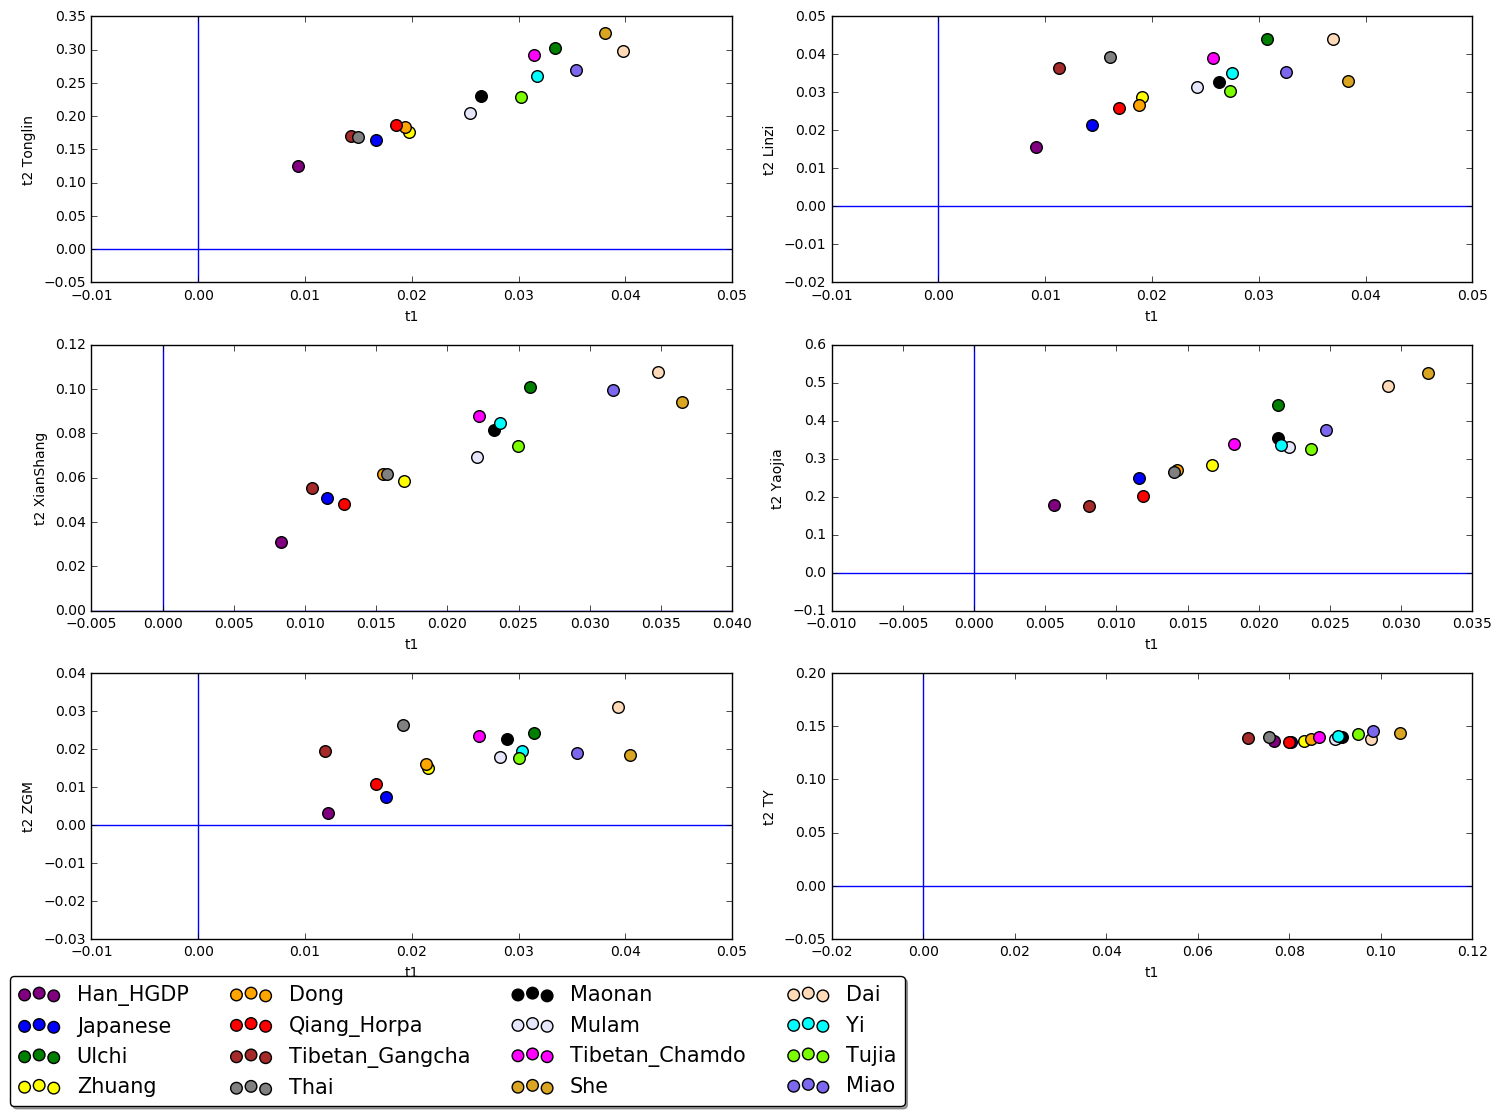

In [32]:
%matplotlib inline

import cPickle
import matplotlib.pyplot as plt
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
addon="_switchanc_sepDHG"
refpops=["Han_HGDP","Japanese","Ulchi","Zhuang","Dong","Qiang_Horpa","Tibetan_Gangcha",
        "Thai","Maonan","Mulam","Tibetan_Chamdo","She","Dai","Yi","Tujia","Miao"]
        ##"Mongola","Li","Xibo","Oroqen","Naxi","Hezhen","Cambodian", (<10)
print len(refpops)
#refpops=["Han_HGDP"]
mypops=["Tonglin", "Linzi", "XianShang", "Yaojia","ZGM", "TY","DHG1","DHG2","BLK"]
popiwant="TY"
fig = plt.figure(figsize=(15,10))
for myind,popiwant in enumerate(mypops):
    if myind>5: continue
    ax = fig.add_subplot(3,2,myind+1)
    t1f,t2f,t1t,t2t=[],[],[],[]
    for refpop in refpops:
        print "_______________________"
        print refpop
        falsefile=open(pD+"ind_A_v13_TBH"+addon+"."+refpop+"_contFalse.pickle",'r')
        falsedat=cPickle.load(falsefile)
        truefile=open(pD+"ind_A_v13_TBH"+addon+"."+refpop+"_contTrue.pickle",'r')
        truedat=cPickle.load(truefile)
        #print falsedat

        for ind,mypop in enumerate(falsedat):
            #if ind in [0,2,3,4]: continue
            #if ind in [0,1,2,3]: continue
            if mypops[ind] == popiwant:
                print "False", mypops[ind],mypop[1], list(mypop[0])
                print "True", mypops[ind],truedat[ind][1],list(truedat[ind][0])
                t1f.append(mypop[0][0])
                t2f.append(mypop[0][1])
                t1t.append(truedat[ind][0][0])
                t2t.append(truedat[ind][0][1])


    colors=["purple","blue","green","yellow","orange","red","brown",
            "gray","black","lavender","fuchsia","goldenrod","peachpuff","cyan",
            "lawngreen","mediumslateblue","cadetblue","pink","tan","lavenderblush",
            "sage","peru","gainsboro"]
    #print t1f
    for i in range(len(t1f)):
        #handles.append(ax.scatter(t1f[i],t2f[i],c=colors[i],label=refpops[i]))
        ax.scatter(t1f[i],t2f[i],label=refpops[i],c=colors[i],s=70)
    
    #ax.set_xlim((0,0.13))
    #ax.set_ylim((0,0.35))
    ax.set_xlabel("t1")
    ax.set_ylabel("t2 "+popiwant)
    ax.axhline(y=0)
    ax.axvline(x=0)
ax.legend(fontsize=15,bbox_to_anchor=(0.13, -0.1),ncol=4, fancybox=True, shadow=True)
fig.tight_layout()

Tonglin 1e-10 9.99995499595
Linzi 0.00915150144158 0.0155219038525
XianShang 0.00830872902323 0.0311140006705
Yaojia 1e-10 9.99995197394
ZGM 0.0121758596213 0.00320442355155
TY 0.0766242702978 0.135931998905
DHG 0.860403354275 0.746136362656
BLK 0.860403296293 0.746136326885


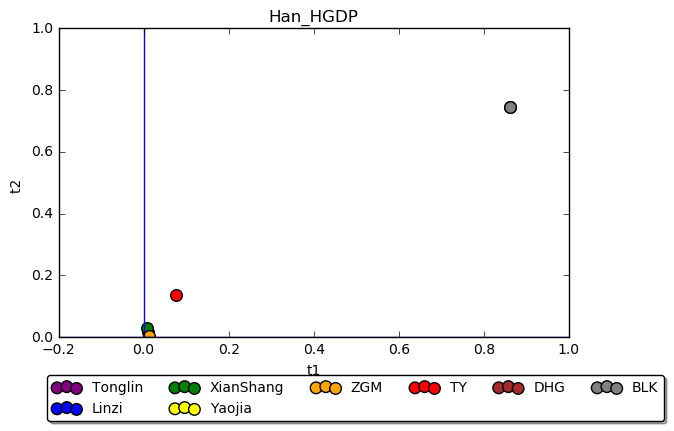

In [18]:
%matplotlib inline

import cPickle
import matplotlib.pyplot as plt
pD="/mnt/solexa/mel_yang/bronzeage/jda/"
addon="_switchanc"
colors=["purple","blue","green","yellow","orange","red","brown",
            "gray","black","lavender","fuchsia","goldenrod","peachpuff","cyan",
            "lawngreen","mediumslateblue"]
myrefs=["Han_HGDP","Japanese","Ulchi","Zhuang","Dong","Qiang_Horpa","Tibetan_Gangcha",
        "Thai","Maonan","Mulam","Tibetan_Chamdo","She","Dai","Yi","Tujia","Miao"]
        ##"Mongola","Li","Xibo","Oroqen","Naxi","Hezhen","Cambodian", (<10)
myrefs=["Han_HGDP"]
mypops=["Tonglin", "Linzi", "XianShang", "Yaojia","ZGM", "TY","DHG","BLK"]
popiwant="TY"

for refpop in myrefs:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for myind,popiwant in enumerate(mypops):
        t1f,t2f,t1t,t2t=[],[],[],[]

        #print "_______________________"
        #print refpop
        falsefile=open(pD+"ind_A_v13_TBH"+addon+"."+refpop+"_contFalse.pickle",'r')
        falsedat=cPickle.load(falsefile)
        truefile=open(pD+"ind_A_v13_TBH"+addon+"."+refpop+"_contTrue.pickle",'r')
        truedat=cPickle.load(truefile)
        #print falsedat

        for ind,mypop in enumerate(falsedat):
            #if ind in [0,2,3,4]: continue
            #if ind in [0,1,2,3]: continue
            if mypops[ind] == popiwant:
                #print "False", mypops[ind],mypop[1], list(mypop[0])
                #print "True", mypops[ind],truedat[ind][1],list(truedat[ind][0])
                t1f.append(mypop[0][0])
                t2f.append(mypop[0][1])
                t1t.append(truedat[ind][0][0])
                t2t.append(truedat[ind][0][1])
                print popiwant, mypop[0][0], mypop[0][1]



        #print t1f
        #for i in range(len(t1f)):
            #handles.append(ax.scatter(t1f[i],t2f[i],c=colors[i],label=refpops[i]))
        i=0
        ax.scatter(t1f[i],t2f[i],label=mypops[myind],c=colors[myind],s=70)
        ax.set_title(refpop)
        #ax.set_xlim((0,0.13))
        ax.set_ylim((0,1))
        ax.set_xlabel("t1")
        ax.set_ylabel("t2 ")
        ax.legend(fontsize=10,bbox_to_anchor=(1.2, -0.1),ncol=6, fancybox=True, shadow=True)
ax.axhline(y=0)
ax.axvline(x=0)
fig.tight_layout()